In [23]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from qiskit_machine_learning.connectors import TorchConnector
import torch

1.2.4
0.7.2


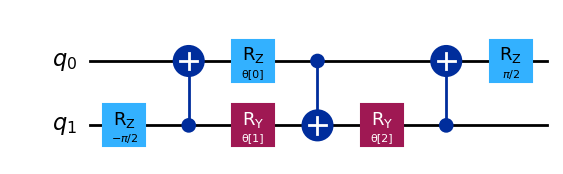

In [24]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

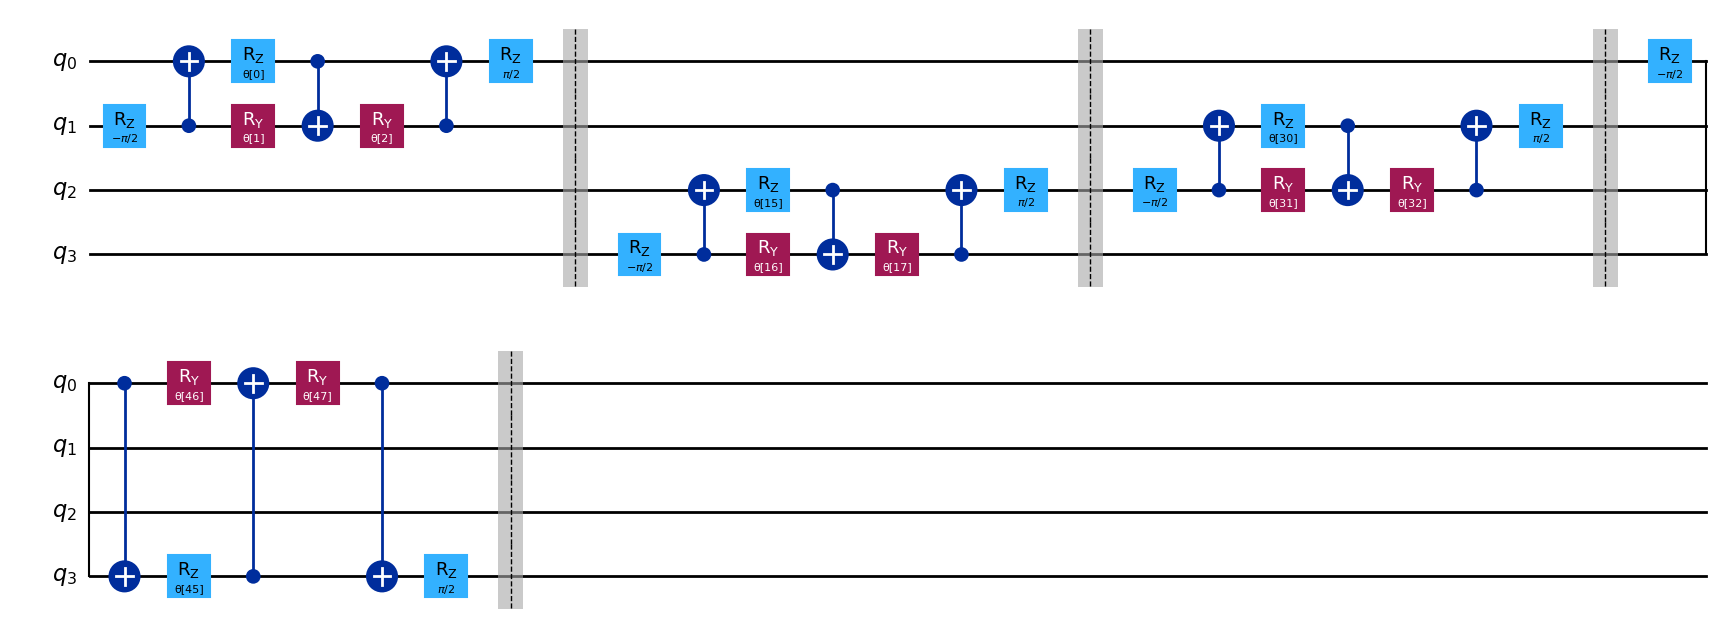

In [25]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

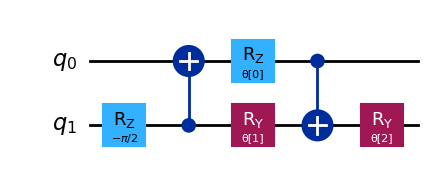

In [26]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

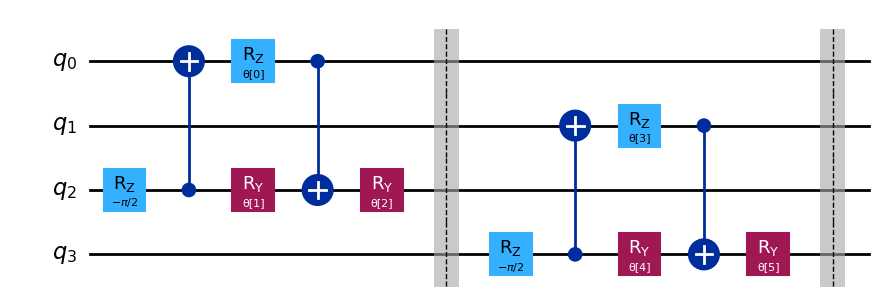

In [27]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [28]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [29]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [30]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


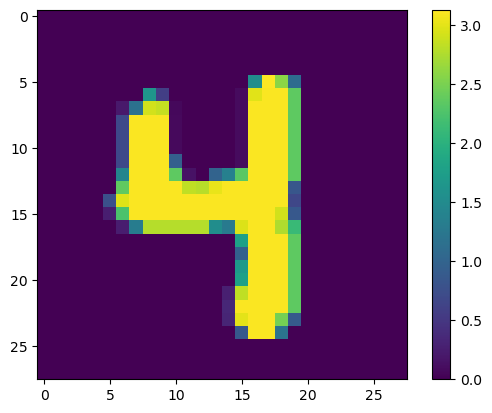

In [31]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [32]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

4


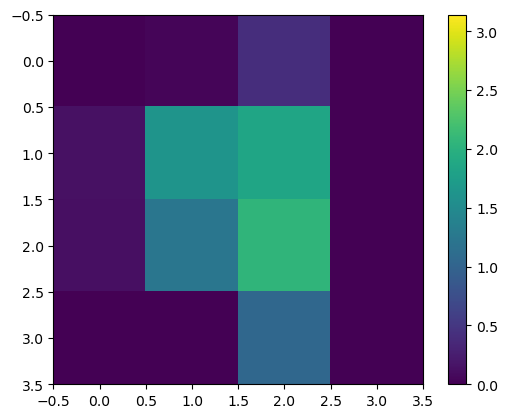

In [33]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [34]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [35]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


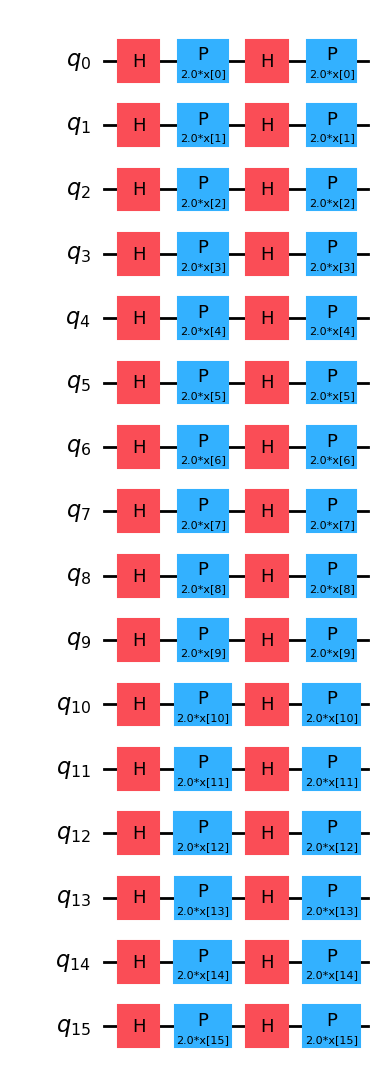

In [36]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

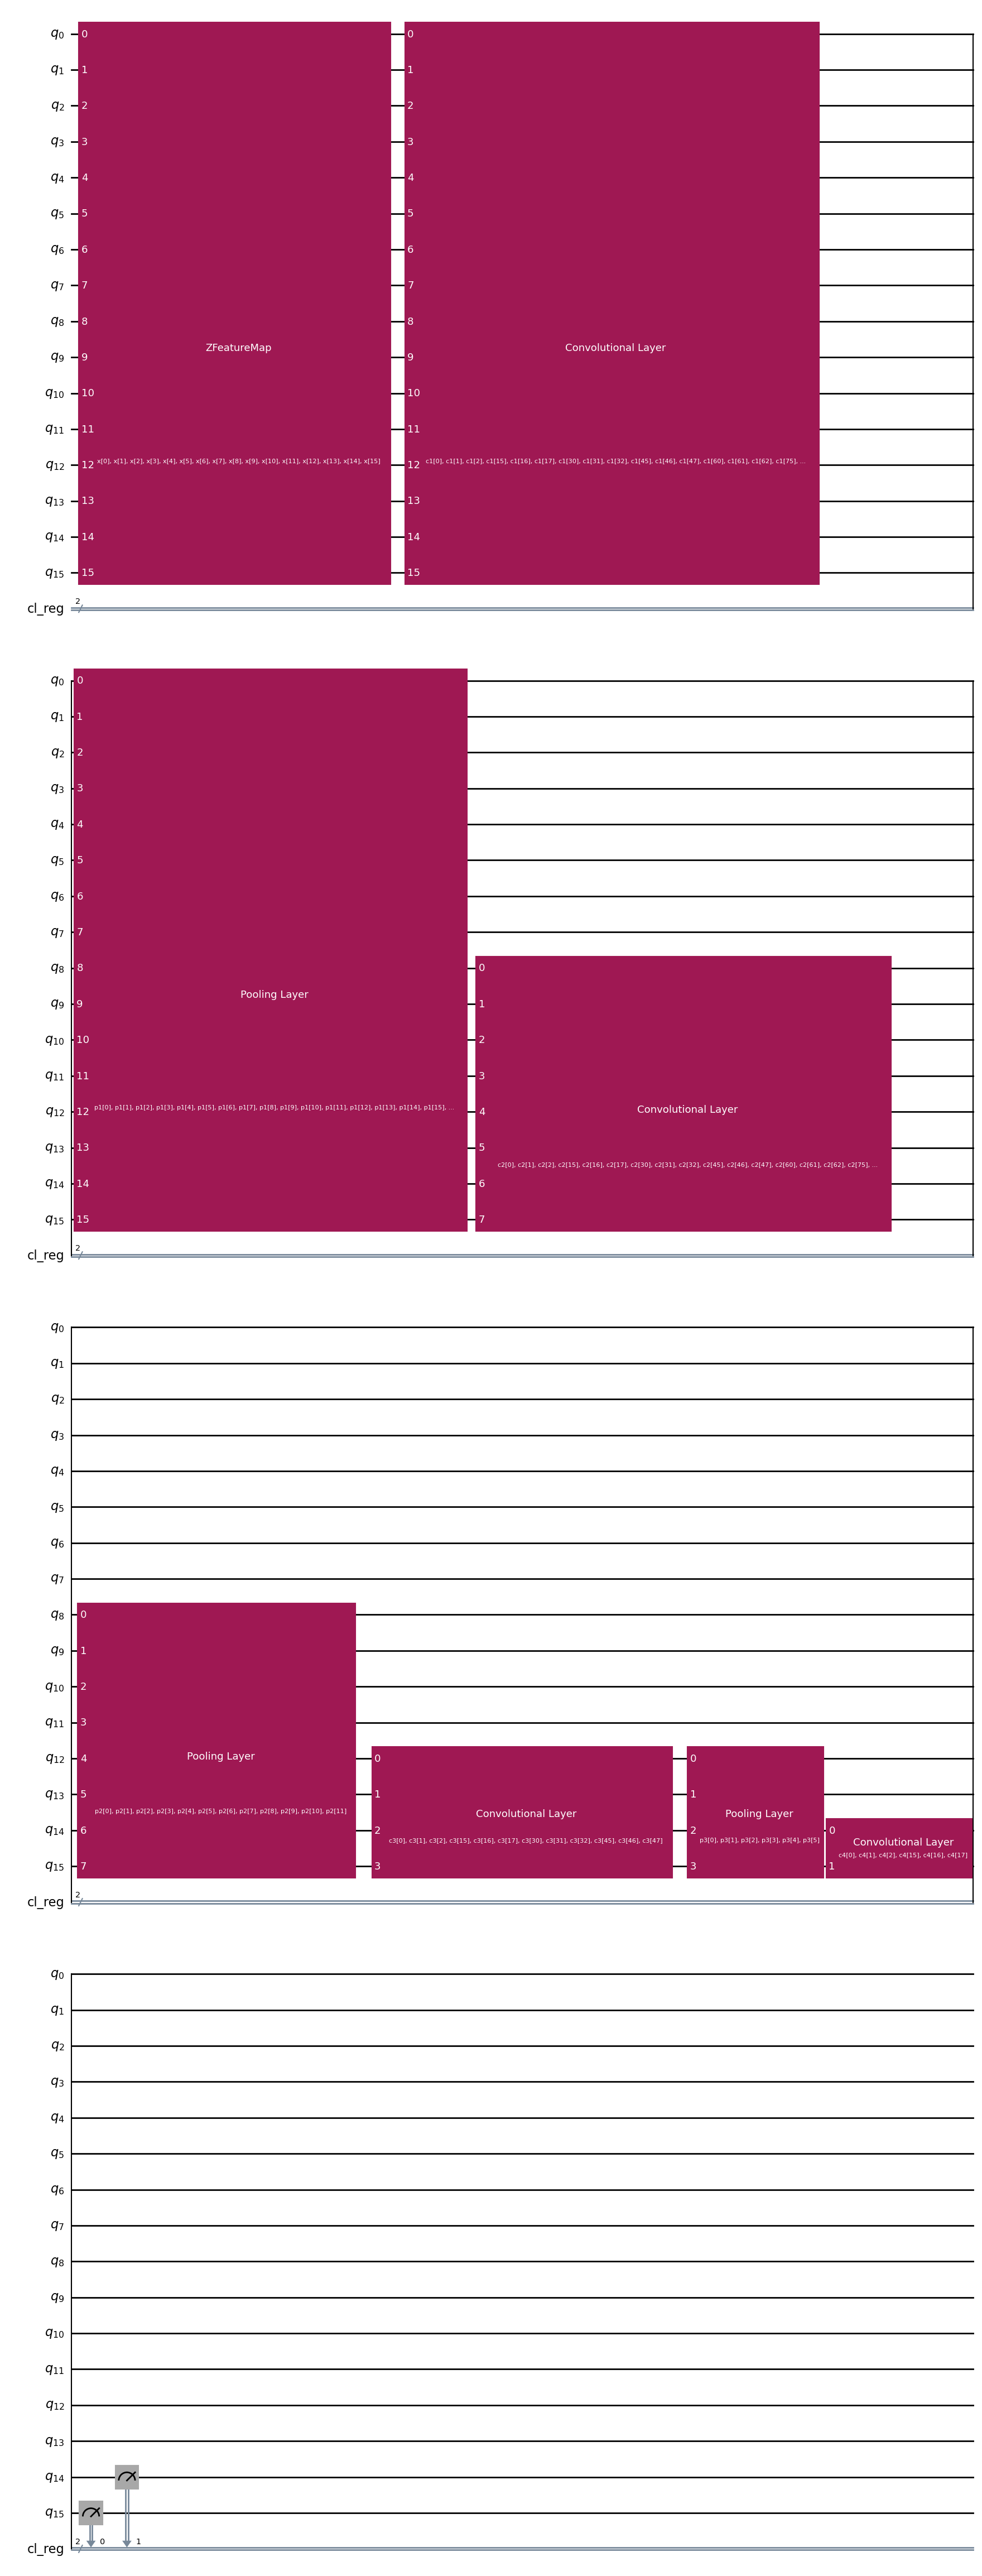

In [37]:
from qiskit import ClassicalRegister, QuantumRegister
q_reg = QuantumRegister(16, "q_reg")
cl_reg = ClassicalRegister(2, "cl_reg")
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(q_reg, cl_reg, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)
ansatz.measure(-1,0)
ansatz.measure(-2,1)

# Combining the feature map and ansatz
circuit = QNNCircuit(16)
circuit.feature_map = feature_map
circuit.ansatz = ansatz

display(circuit.draw("mpl"))

In [38]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0, 1, or 2 to properly process in samplerqnn.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    else: y_temp.append(2)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    else: y1_temp.append(2)
y1=y_temp

x = x[0:6]
y = y[0:6]
x1 = x1[0:6]
y1 = y1[0:6]

x = Tensor(x)
y = Tensor(y)
y = y.squeeze().long()
y1 = y1.squeeze().long()

print(x)
print(y)

tensor([[0.0360, 0.0000, 0.0470, 0.1232, 0.7696, 0.0000, 0.8390, 0.1604, 0.4571,
         0.7040, 1.2053, 0.0000, 0.0000, 0.0000, 0.5469, 0.0000],
        [0.0000, 0.2690, 0.8697, 0.0448, 0.0000, 0.7500, 2.1630, 0.2434, 0.0626,
         0.8126, 1.6730, 0.0000, 0.2849, 1.3766, 0.4684, 0.0000],
        [0.0000, 0.0000, 0.0342, 0.3764, 0.0000, 0.7538, 0.9232, 0.2208, 0.0976,
         1.4942, 1.1752, 0.0000, 0.0000, 0.4320, 0.0000, 0.0000],
        [0.0000, 0.5003, 0.5798, 0.0000, 0.0000, 0.8043, 1.9287, 0.0000, 0.0460,
         0.4392, 1.4719, 0.0000, 0.0143, 1.0135, 0.3797, 0.0000],
        [0.3128, 0.7495, 0.2650, 0.0000, 0.2919, 0.9318, 1.5010, 0.0000, 0.0000,
         0.3887, 1.8068, 0.4739, 0.0000, 1.1070, 1.1470, 0.0158],
        [0.1370, 0.0000, 0.3387, 0.0000, 1.0832, 0.6409, 1.6863, 0.0000, 0.0817,
         1.7841, 2.1980, 0.0505, 0.0000, 0.0000, 0.4076, 0.1810]])
tensor([1, 0, 1, 0, 0, 1])


In [40]:
torch.cuda.is_available()

True

In [41]:
y

tensor([1, 0, 1, 0, 0, 1])

In [ ]:
classifier = SamplerQNN(
    circuit = circuit,
    output_shape = 2,
    interpret = lambda x: x%2,
    )

initial_weights = 0.1 * (2 * algorithm_globals.random.random(classifier.num_weights) - 1)
print("Initial weights: ", initial_weights)
model = TorchConnector(classifier, initial_weights)

# Define model, optimizer, and loss
optimizer = LBFGS(model.parameters(), lr=0.1)
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range
#f_loss = MSELoss(reduction='sum')

# Start training
model.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    print(f"Input tensor shape: {model(x).shape}")
    print(f"Target tensor shape: {y.shape}")
    loss = f_loss(model(x), y)  # Calculate loss
    loss.backward()  # Backward pass
    print(loss.item())
    return loss

device = torch.device("cuda:0")
classifier.to(device)


Initial weights:  [-0.06488705  0.02492852  0.05929239  0.06341601  0.03340342  0.02093293
  0.02212758 -0.09835713 -0.08349686 -0.04264005  0.07891187  0.07730386
  0.09536291 -0.01755569 -0.05821129  0.00328148 -0.07309709  0.07590203
 -0.03250208  0.0440252  -0.0305665   0.03741009  0.03213016 -0.07285671
  0.09519287  0.04694303  0.08819211  0.01192726  0.07621108  0.01563477
 -0.05691562 -0.03133863 -0.08005685 -0.09062626 -0.0377261  -0.0841036
  0.09394111 -0.08269761 -0.01068269 -0.03321545  0.03569965 -0.03062773
 -0.09255951  0.0622135  -0.08893964  0.06067591  0.02133581  0.06996269
  0.02280277  0.02162076  0.04514301 -0.06797789 -0.06614042  0.09299039
  0.02342967 -0.05918871  0.00109261  0.07750943 -0.00784873  0.05729116
  0.08858988 -0.02890679  0.07032536 -0.07489103  0.08365281  0.00117408
 -0.06405631 -0.03272516 -0.04237631 -0.09373999 -0.05162841 -0.06749924
  0.01269342 -0.05644306 -0.0143637   0.09033462 -0.04669902 -0.0369824
  0.08337197  0.06613341  0.0368515

In [ ]:
# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

Input tensor shape: torch.Size([6, 2])
Target tensor shape: torch.Size([6])


In [ ]:
# Evaluate model and compute accuracy
classifier.eval()
y_predict = []
for x in x:
    output = classifier(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y) / len(y))

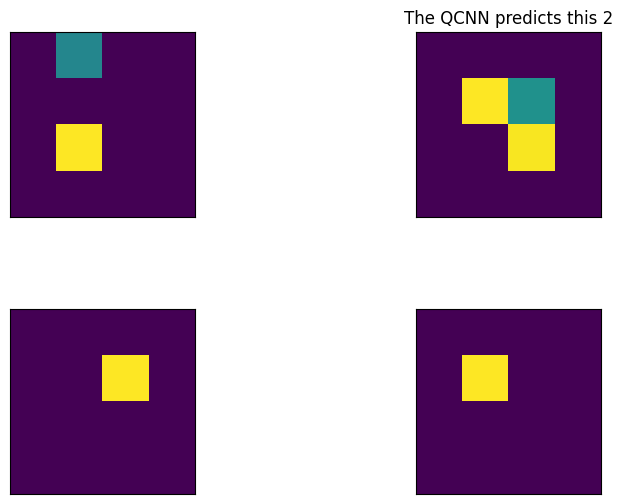

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 1")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 2")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    # if y_predict[i] == 9:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [92]:
y_predict

array([0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
      dtype=int64)

In [91]:
y1

array([2, 0, 1, 0, 0, 3, 0, 0, 3, 1, 3, 2, 2, 2, 2, 0, 3, 0, 0, 2],
      dtype=uint8)